In [12]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

from utils.load_data import load_distributional_dataset
from models.flow_forward import FlowForwardModel
from config import DISTRIBUTIONAL_DATA_PATH

# === setup ===
trial = 5
model_type = "flow"
flow_type = "planar"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === paths ===
base_dir = f"checkpoints/{model_type}/{flow_type}/{flow_type}_trial_{trial}"
config_path = f"{base_dir}/config_{trial}.txt"
model_path = f"{base_dir}/{flow_type}_ckpt_{trial}.pt"

# === load config from file ===
with open(config_path, "r") as f:
    lines = f.readlines()
config_dict = {
    line.split(":")[0].strip(): eval(line.split(":")[1].strip())
    for line in lines if ":" in line
}

# === extract config values ===
S_DIM = config_dict["S_DIM"]
P_DIM = config_dict["P_DIM"]
HIDDEN_DIMS = config_dict["HIDDEN_DIMS"]
NUM_FLOWS = config_dict["NUM_FLOWS"]

# === load model ===
model = FlowForwardModel(S_DIM, P_DIM, hidden_dims=HIDDEN_DIMS, num_flows=NUM_FLOWS, flow_type=flow_type).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("✅ Loaded flow forward model from trial", trial)

# === print config ===
print("✅ Config for trial", trial)
for k, v in config_dict.items():
    print(f"   - {k}: {v}")

✅ Loaded flow forward model from trial 5
✅ Config for trial 5
   - S_DIM: 4
   - P_DIM: 9
   - HIDDEN_DIMS: [128, 64, 32]
   - NUM_FLOWS: 3
   - BATCH_SIZE: 32
   - LEARNING_RATE: 0.0005
   - NUM_EPOCHS: 500
   - BETA_VAR_REG: 0.01


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_20933/3503037408.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

In [13]:
# === load empirical distributional dataset ===
empirical_data = load_distributional_dataset(DISTRIBUTIONAL_DATA_PATH)
S_keys = list(empirical_data.keys())
print(f"✅ Loaded {len(S_keys)} unique S values.")

# === pick a structure S to analyze ===
S_val = np.array(S_keys[0])  # change index here to test others
P_true_samples = empirical_data[S_keys[0]]
print(f"✅ Empirical P samples for S={S_val}: shape {P_true_samples.shape}")

# === convert S to torch tensor ===
S_val_torch = torch.tensor(S_val, dtype=torch.float32).unsqueeze(0).to(device)

✅ Loaded 30 unique S values.
✅ Empirical P samples for S=[39.383007  34.080853   0.         0.6440046]: shape (100, 9)


In [14]:
# === prediction and sampling function ===
def get_P_predictions(S_val_torch, num_samples=100):
    S_tensor = S_val_torch.repeat(num_samples, 1).to(device)
    with torch.no_grad():
        z_k, _, mu, log_sigma = model(S_tensor)
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(mu)
        P_samples = mu + sigma * eps
    return mu[0].cpu().numpy(), sigma[0].cpu().numpy(), P_samples.cpu().numpy()

# === run prediction ===
mu_pred, sigma_pred, P_hats = get_P_predictions(S_val_torch, num_samples=100)

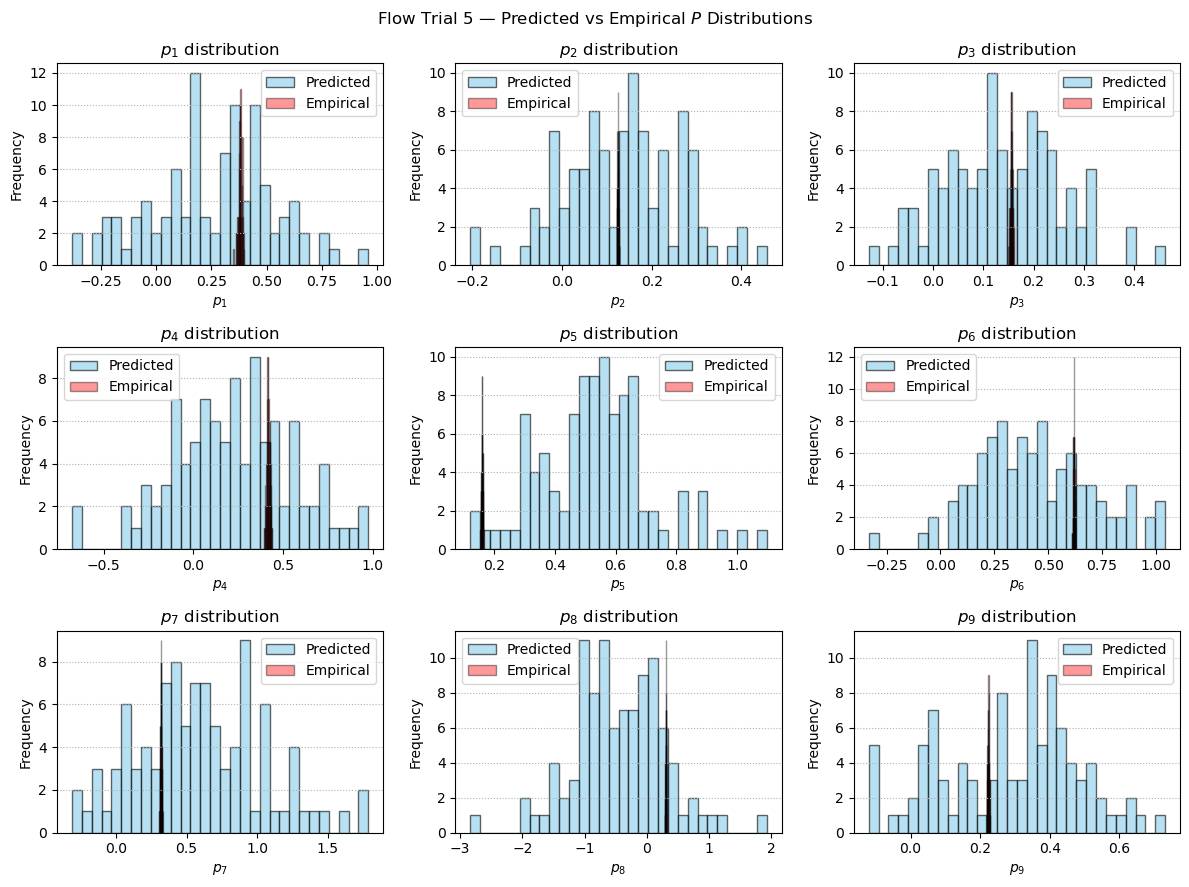

In [15]:
# === histogram plots ===
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
axs = axs.flatten()
for i in range(9):
    axs[i].hist(P_hats[:, i], bins=30, color='skyblue', alpha=0.6, edgecolor='black', label='Predicted')
    axs[i].hist(P_true_samples[:, i], bins=30, color='red', alpha=0.4, edgecolor='black', label='Empirical')
    axs[i].set_title(f"$p_{{{i+1}}}$ distribution")
    axs[i].set_xlabel(f"$p_{{{i+1}}}$")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()
    axs[i].grid(True, linestyle=':', axis='y')
plt.suptitle(f"Flow Trial {trial} — Predicted vs Empirical $P$ Distributions")
plt.tight_layout()
plt.show()

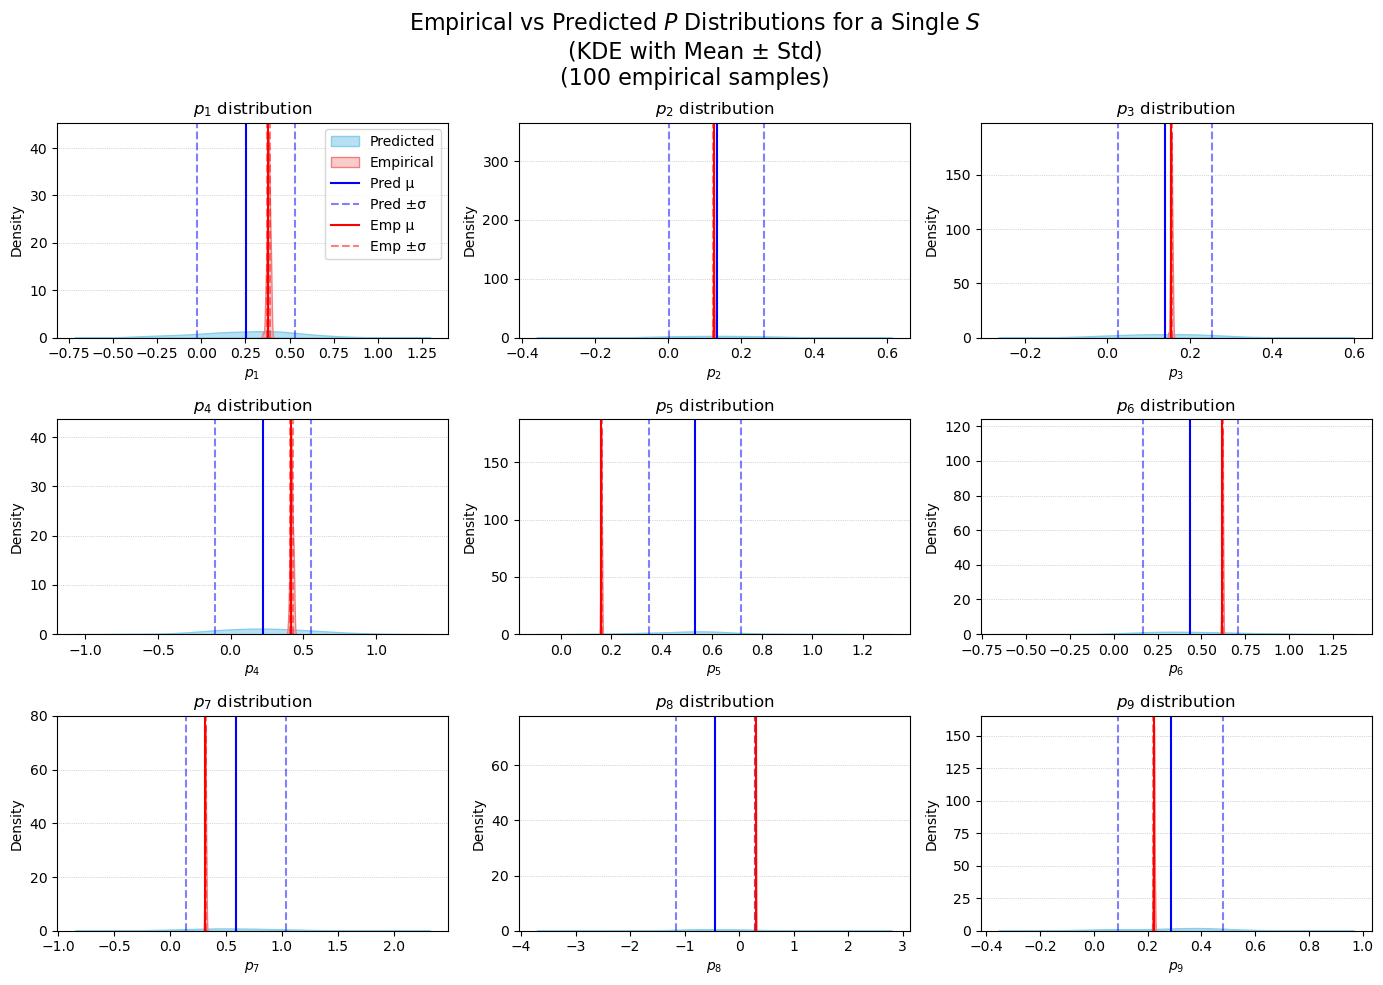


P      μ_emp   μ_pred    σ_emp   σ_pred      Δμ    σ*/σ       KL
-----------------------------------------------------------------
p1     0.380    0.256    0.009    0.277  -0.125   30.21    2.107
p2     0.124    0.133    0.001    0.130   0.008  119.24    3.497
p3     0.155    0.139    0.002    0.114  -0.016   53.27    3.219
p4     0.418    0.222    0.010    0.329  -0.196   34.01    2.415
p5     0.161    0.534    0.002    0.182   0.373   84.36    4.605
p6     0.620    0.436    0.003    0.271  -0.183   86.07    2.813
p7     0.318    0.592    0.005    0.447   0.274   85.77    2.390
p8     0.304   -0.435    0.005    0.731  -0.739  141.09    2.813
p9     0.223    0.286    0.002    0.195   0.063   86.03    3.291
-----------------------------------------------------------------
AVG                                                        3.017


In [16]:
fig, axs = plt.subplots(3, 3, figsize=(14, 10))
axs = axs.flatten()

for i in range(9):
    pred = P_hats[:, i]
    true = P_true_samples[:, i]

    # Compute means and stds
    mu_pred, std_pred = np.mean(pred), np.std(pred)
    mu_true, std_true = np.mean(true), np.std(true)

    # Plot KDEs
    sns.kdeplot(pred, ax=axs[i], fill=True, color='skyblue', alpha=0.6, label='Predicted')
    sns.kdeplot(true, ax=axs[i], fill=True, color='lightcoral', alpha=0.4, label='Empirical')

    # Plot vertical lines: mean ± std
    axs[i].axvline(mu_pred, color='blue', linestyle='-', label='Pred μ')
    axs[i].axvline(mu_pred + std_pred, color='blue', linestyle='--', alpha=0.5, label='Pred ±σ')
    axs[i].axvline(mu_pred - std_pred, color='blue', linestyle='--', alpha=0.5)

    axs[i].axvline(mu_true, color='red', linestyle='-', label='Emp μ')
    axs[i].axvline(mu_true + std_true, color='red', linestyle='--', alpha=0.5, label='Emp ±σ')
    axs[i].axvline(mu_true - std_true, color='red', linestyle='--', alpha=0.5)

    # Axis styling
    axs[i].set_title(f"$p_{{{i+1}}}$ distribution")
    axs[i].set_xlabel(f"$p_{{{i+1}}}$")
    axs[i].set_ylabel("Density")
    axs[i].grid(True, axis='y', linestyle=':', linewidth=0.5)

    if i == 0:
        axs[i].legend()

fig.suptitle(f"Empirical vs Predicted $P$ Distributions for a Single $S$\n(KDE with Mean ± Std)\n({P_true_samples.shape[0]} empirical samples)", fontsize=16)
plt.tight_layout()
plt.show()

# === summary stats and KL divergence ===
print(f"\n{'P':<3} {'μ_emp':>8} {'μ_pred':>8} {'σ_emp':>8} {'σ_pred':>8} {'Δμ':>7} {'σ*/σ':>7} {'KL':>8}")
print("-" * 65)
kl_vals = []
for i in range(9):
    emp, pred = P_true_samples[:, i], P_hats[:, i]
    mu_emp, mu_pred_i = np.mean(emp), np.mean(pred)
    std_emp, std_pred = np.std(emp), np.std(pred)
    bins = np.histogram_bin_edges(np.concatenate([emp, pred]), bins=30)
    emp_hist, _ = np.histogram(emp, bins=bins, density=True)
    pred_hist, _ = np.histogram(pred, bins=bins, density=True)
    emp_hist += 1e-10
    pred_hist += 1e-10
    kl = entropy(emp_hist, pred_hist)
    kl_vals.append(kl)
    print(f"p{i+1:<2} {mu_emp:8.3f} {mu_pred_i:8.3f} {std_emp:8.3f} {std_pred:8.3f} {mu_pred_i - mu_emp:7.3f} {std_pred/std_emp if std_emp > 0 else float('inf'):7.2f} {kl:8.3f}")
print("-" * 65)
print(f"{'AVG':<3} {'':>8} {'':>8} {'':>8} {'':>8} {'':>7} {'':>7} {np.mean(kl_vals):8.3f}")
